In [1]:
from stable_baselines3.sac.policies import MlpPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import SAC
import logging
import gym
import numpy as np
import os

# add reference libraries here. Current structure will use the relative path from this file
libs = ["../../../OpenIPSL-1.5.0/OpenIPSL/package.mo",
       "../../../OpenIPSL-1.5.0/ApplicationExamples/IEEE9/package.mo"]

# check that all the paths to library package.mo files exist
# DymolaInterface() also checks this but I've found this warning helpful
for lib in libs:
    if not os.path.isfile(lib):
        print(f"Cannot find the library {lib}")

mo_name = "IEEE9.IEEE_9_wVariation" # name of Modelica model in the Library.Model format
env_entry_point = 'examples:IEEE9Env' # Python package location of RL environment

time_step = 1 # time delta in seconds
positive_reward = 1
negative_reward = -100 # penalize RL agent for is_done
log_level = 0
default_action = [0,0,0]

# these config values are passed to the model specific environment class
# mo_name and libs are passed on to the DymolaBaseEnv class
config = {
    'mo_name': mo_name,
    'libs': libs,
#     'actions': actions,
#     'states': states,
    'time_step': time_step,
    'positive_reward': positive_reward,
    'negative_reward': negative_reward,
    'log_level': log_level,
    'default_action': default_action,
    'method':'DASSL'
}

# enable the model specific class as an OpenAI gym environment
from gym.envs.registration import register
env_name = "MicrogridEnv-v0"

register(
    id=env_name,
    entry_point=env_entry_point,
    kwargs=config
)

In [2]:
# create the environment. this will run an initial step and must return [True, [...]] or something is broken
# TODO: create error handling/warnings if simulations don't work (i.e. returns [False], [...])
env = gym.make(env_name)

resetting dymola...
dymola has been reset
the model will be reset
the model has been reset


C:\Users\Aisling\.conda\envs\myenv\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [5]:
mode = 'load'

if mode == 'load':
    model = SAC.load("IEEE9_5k_v3", env=env)
else:
    model = SAC(MlpPolicy, env, learning_rate=10**-4, verbose=1)
    

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [4]:
import time

tic = time.time()

model.learn(50, reset_num_timesteps=False)
model.save("IEEE9_5k_v4")

toc = time.time()
print(toc-tic)

the model will be reset
the model has been reset
64.15680575370789


In [ ]:
env.reset()

In [13]:
env.tau = 5

In [14]:
# show performance over 10 seconds in a do-nothing case (control voltage set at 1.0 pu)
obs = env.reset()
sum_rewards = 0
dn_voltage = []
for i in range(nsteps):
#     print(i)
    action = [0,0,0] # weird behavior where the model thinks the action output by model.predict has len() = 2
    obs, reward, done, info = env.step(action)
#     print(env.start)
#     if done:
#         env.reset()
    dn_voltage += env.state[:9]
    sum_rewards += reward

the model will be reset
the model has been reset


NameError: name 'nsteps' is not defined

In [ ]:
# show performance over 10 seconds in a do-nothing case (control voltage set at 1.0 pu)
obs = env.reset()
# action = model.predict(obs)
rand_sum_rewards = 0
rand_voltage = []
for i in range(nsteps):
#     print(i)
    action = env.action_space.sample() # forces change in p_mech reference for dispatch
    obs, reward, done, info = env.step(action)
#     print(env.state)
    rand_voltage += env.state[:9]
    rand_sum_rewards += reward

In [ ]:
# show performance over 10 seconds in a do-nothing case (control voltage set at 1.0 pu)
obs = env.reset()
# action = model.predict(obs)
rl_sum_rewards = 0
b_voltage = []
for i in range(nsteps):
#     print(i)
    action = model.predict(obs)[0] # forces change in p_mech reference for dispatch
    obs, reward, done, info = env.step(action)
#     print(env.state)
    b_voltage += env.state[:9]
    rl_sum_rewards += reward

0
not that great
1
not that great
2
not that great
3
not that great
5
6
7
8


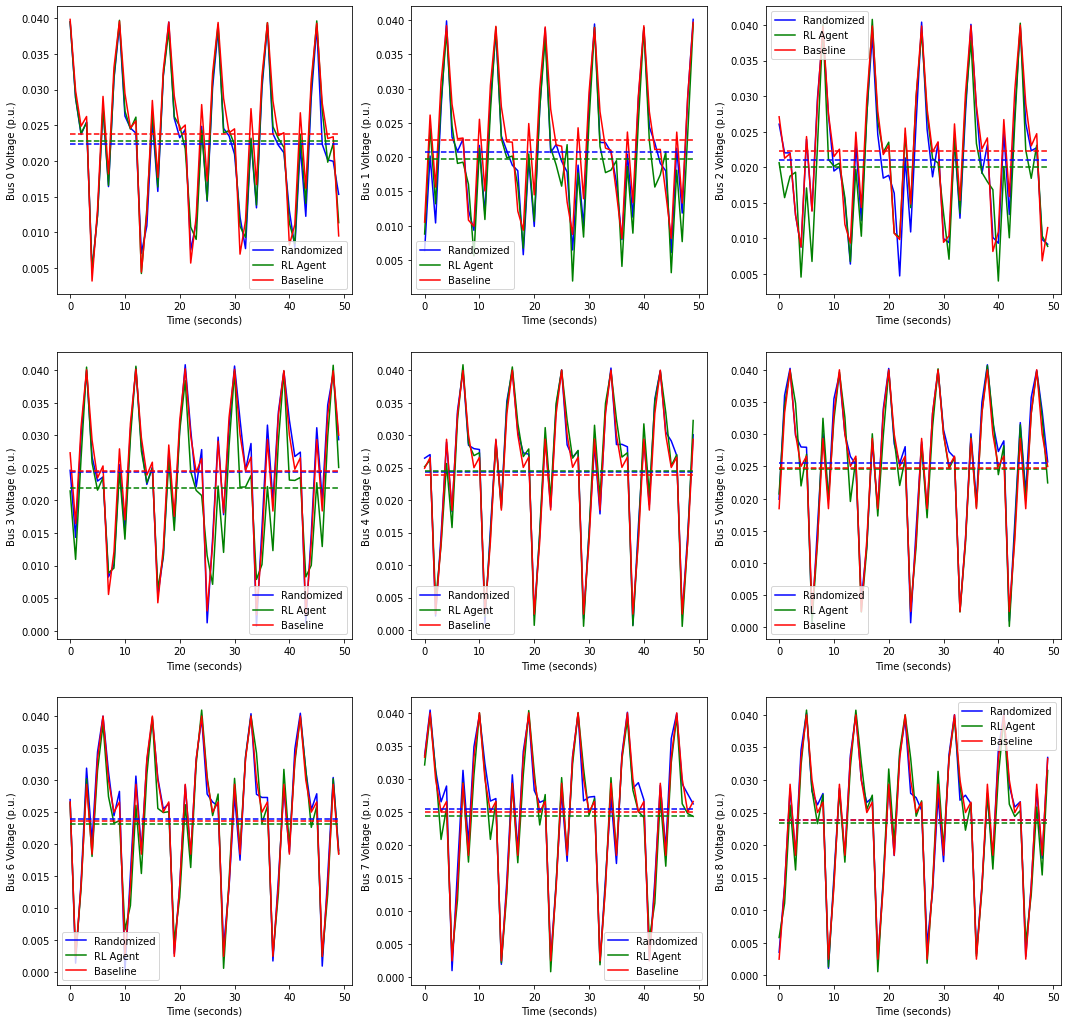

In [12]:
from matplotlib import pyplot as plt 
import numpy as np
    
# x-axis values 
x = np.arange(nsteps) 
fig, ax = plt.subplots(3,3, figsize=(18,18))  
for i in range(3):
    for j in range(3):
        # Y-axis values 
        w = np.reshape(rand_voltage, (9,-1))[3*i+j,:]
        y = np.reshape(b_voltage, (9,-1))[3*i+j,:]
        z = np.reshape(dn_voltage, (9,-1))[3*i+j,:]
#         print(sum(abs(w-1))/50)
#         print(sum(abs(y-1))/50)
#         print(sum(abs(z-1))/50)
        # Function to plot scatter 
        ax[i][j].plot(x, abs(w-1), 'b-')
        ax[i][j].plot(x, abs(y-1), 'g-') 
        ax[i][j].plot(x, abs(z-1), 'r-')
        
        ax[i][j].plot(x, np.mean(abs(w-1))*np.ones(nsteps), 'b--')
        ax[i][j].plot(x, np.mean(abs(y-1))*np.ones(nsteps), 'g--') 
        ax[i][j].plot(x, np.mean(abs(z-1))*np.ones(nsteps), 'r--')
        
        if np.mean(abs(y-1)) < np.mean(abs(z-1)):
            print(3*i+j)
            if np.mean(abs(w-1))  < np.mean(abs(z-1)):
                print('not that great')
        ax[i][j].legend(['Randomized', 'RL Agent', 'Baseline'])
        ax[i][j].set_xlabel('Time (seconds)')
        ax[i][j].set_ylabel(f'Bus {3*i+j} Voltage (p.u.)')
        # function to show the plot 
plt.show()

In [ ]:
from matplotlib import pyplot as plt 
 
    
# x-axis values 
x = np.arange(50) 
fig, ax = plt.subplots(3,3, figsize=(18,18))  
for i in range(3):
    for j in range(3):
        # Y-axis values 
        w = np.reshape(rand_voltage, (9,-1))[3*i+j,:]
        y = np.reshape(b_voltage, (9,-1))[3*i+j,:]
        z = np.reshape(dn_voltage, (9,-1))[3*i+j,:]
        print(sum(abs(w-1))/50)
        print(sum(abs(y-1))/50)
        print(sum(abs(z-1))/50)
        # Function to plot scatter 
        ax[i][j].plot(x, w)
        ax[i][j].plot(x, y) 
        ax[i][j].plot(x, z)
        ax[i][j].legend(['Randomized', 'RL Agent', 'Baseline'])
        ax[i][j].set_xlabel('Time (seconds)')
        ax[i][j].set_ylabel(f'Bus {3*i+j} Voltage (p.u.)')
        # function to show the plot 
plt.show()

In [ ]:
env.dymola.getLastError()